#### Start by importing packages and setting the working directory

In [1]:
#get occurrence data for set of species
from shapely.affinity import scale
from shapely.geometry import Point
from shapely.ops import transform
from shapely.geometry import Polygon
import pandas as pd
from pygbif.species import name_backbone
from pygbif import occurrences as occ
import geopandas as gpd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

file_dir=r'C:/Users/Mark.Rademaker/PycharmProjects/InternshipNaturalis/venv/github_trait_geo_diverse_dl/trait-geo-diverse-dl'

In [2]:
#Open shapefile
# Set filepath (fix path relative to yours)
dist = file_dir+"/data/IUCN_mammal_ranges/TERRESTRIAL_MAMMALS.shp"

# Read file using gpd.read_file()
dist_shp = gpd.read_file(dist)

#### Get backbone taxonomy code for each species

In [3]:
#Create the dataframes to be concatenated and filtered
occ_all_species = pd.read_csv(file_dir+"/data/SQL_raw_gbif/occurrences_all_species.csv")
df = occ_all_species[occ_all_species['label'].str.contains(" ")]

print("oc_all_species n.rows: ",len(occ_all_species.index))
print("df n.rows: ",len(occ_all_species.index))

#Get unique label names
labels=df["label"].tolist()
unique_labels=df["label"].unique()

names = []
back_key =[]
remaining_labels=[]

#Get backbone associated species names and taxon keys
for item in unique_labels:
    if "species" in name_backbone(item):
        i = name_backbone(item)['species']
        j = name_backbone(item)['usageKey']
        #print(item,j,i)
        names.append(i)
        back_key.append(j)
    else:
        remaining_labels.append(item)
print(len(names))
for item in remaining_labels:
    value=name_backbone(item)['usageKey']
    back_key.append(value)
    names.append(item)
print(len(names))    

C:\Users\Mark.Rademaker\PycharmProjects\InternshipNaturalis\venv\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


oc_all_species n.rows:  834182
df n.rows:  834182
875
876


In [4]:
#Put into DataFrame
df=pd.DataFrame({"label": unique_labels,"back_key": back_key,"species": names},columns=["label","back_key","species"])

In [5]:
#Concatenate with occurrence data, dataframe, drop na's 
df2=pd.merge(occ_all_species,df,how="left",on="label")
print("df2 n.rows:", len(df2.index))

df2 = df2[pd.notnull(df2['species'])]
df2 = df2[pd.notnull(df2['decimal_latitude'])]
df2 = df2[pd.notnull(df2['decimal_longitude'])]
print("df2 without na's n.rows:", len(df2.index))

df2["back_key"]=df2["back_key"].astype(int)


df2 n.rows: 834182
df2 without na's n.rows: 797372


In [10]:
#list of species
species = df2["species"].unique()
species.sort()

#save separate dataframe for each species as csv file 
for spec in species:
    data=df2.loc[df2['species'] == spec]
    if len(data.index)>= 10:
        spec=spec.replace(" ","_")
        print("%s"%spec, len(data.index))
        data.to_csv(file_dir+'/data/SQL_raw_gbif/%s_raw_data.csv'%spec)

Addax_nasomaculatus 113
Aepyceros_melampus 2359
Aguascalientia_panamaensis 35
Alcelaphus_buselaphus 1098
Alcelaphus_caama 26
Alcelaphus_lichtensteinii 15
Alces_alces 19015
Alces_americanus 2224
Ammodorcas_clarkei 10
Ammotragus_lervia 1231
Anchitherium_clarencei 77
Antidorcas_marsupialis 569
Antilocapra_americana 1725
Antilope_cervicapra 328
Aphelops_malacorhinus 286
Aphelops_mutilus 46
Archaeohippus_blackbergi 7071
Astrohippus_curtivallis 16
Auchenia_hesterna 99
Auchenia_major 54
Auchenia_minimus 30
Axis_axis 271
Axis_calamianensis 11
Axis_porcinus 374
Babyrousa_celebensis 11
Bison_antiquus 90
Bison_bison 1274
Bison_bonasus 801
Blastocerus_dichotomus 347
Blastomeryx_floridanus 553
Bos_frontalis 64
Bos_grunniens 26
Bos_javanicus 549
Bos_latifrons 189
Bos_taurus 10120
Boselaphus_tragocamelus 135
Bubalus_bubalis 1786
Budorcas_taxicolor 20
Calippus_maccartyi 13
Calippus_martini 11
Camelops_minidokae 44
Camelus_dromedarius 3801
Capra_hircus 15464
Capra_ibex 55646
Capra_nubiana 302
Capra_pyr

Filter data based on lon-lat decimals (>2), unique lon-lat locations, IUCN species range and year

processing species Addax_nasomaculatus
length data 113
length only including lon-lat 2 decimals 108
length unique lon-lat 4


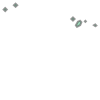

length in species dist polygon 0
length observationas >1900 0
processing species Aepyceros_melampus
length data 2359
length only including lon-lat 2 decimals 2313
length unique lon-lat 1119


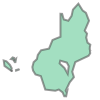

length in species dist polygon 966


C:\Users\Mark.Rademaker\PycharmProjects\InternshipNaturalis\venv\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Mark.Rademaker\PycharmProjects\InternshipNaturalis\venv\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Mark.Rademaker\PycharmProjects\InternshipNaturalis\venv\lib\site-packages\ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

length observationas >1900 966


19

processing species Aguascalientia_panamaensis
length data 35
length only including lon-lat 2 decimals 35
length unique lon-lat 1


length in species dist polygon 0
length observationas >1900 0
processing species Alcelaphus_buselaphus
length data 1098
length only including lon-lat 2 decimals 1080
length unique lon-lat 920


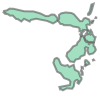

length in species dist polygon 864
length observationas >1900 863


22

processing species Alcelaphus_caama
length data 26
length only including lon-lat 2 decimals 25
length unique lon-lat 15


length in species dist polygon 0
length observationas >1900 0
processing species Alcelaphus_lichtensteinii
length data 15
length only including lon-lat 2 decimals 12
length unique lon-lat 9


length in species dist polygon 0
length observationas >1900 0
processing species Alces_alces
length data 19015
length only including lon-lat 2 decimals 18845
length unique lon-lat 12682


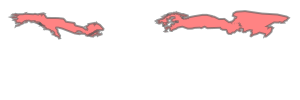

length in species dist polygon 10483
length observationas >1900 10480


12

processing species Alces_americanus
length data 2224
length only including lon-lat 2 decimals 2203
length unique lon-lat 2002


length in species dist polygon 0
length observationas >1900 0
processing species Ammodorcas_clarkei
length data 10
length only including lon-lat 2 decimals 9
length unique lon-lat 2


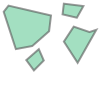

length in species dist polygon 0
length observationas >1900 0
processing species Ammotragus_lervia
length data 1231
length only including lon-lat 2 decimals 1069
length unique lon-lat 423


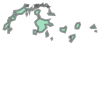

length in species dist polygon 5
length observationas >1900 5
processing species Anchitherium_clarencei
length data 77
length only including lon-lat 2 decimals 74
length unique lon-lat 6


length in species dist polygon 0
length observationas >1900 0
processing species Antidorcas_marsupialis
length data 569
length only including lon-lat 2 decimals 558
length unique lon-lat 386


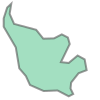

length in species dist polygon 330
length observationas >1900 330


23

processing species Antilocapra_americana
length data 1725
length only including lon-lat 2 decimals 1698
length unique lon-lat 1469


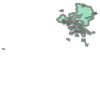

length in species dist polygon 800
length observationas >1900 794


22

processing species Antilope_cervicapra
length data 328
length only including lon-lat 2 decimals 322
length unique lon-lat 61


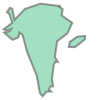

length in species dist polygon 22
length observationas >1900 22


20

processing species Aphelops_malacorhinus
length data 286
length only including lon-lat 2 decimals 11
length unique lon-lat 4


length in species dist polygon 0
length observationas >1900 0
processing species Aphelops_mutilus
length data 46
length only including lon-lat 2 decimals 44
length unique lon-lat 1


length in species dist polygon 0
length observationas >1900 0
processing species Archaeohippus_blackbergi
length data 7071
length only including lon-lat 2 decimals 7069
length unique lon-lat 2


length in species dist polygon 0
length observationas >1900 0
processing species Astrohippus_curtivallis
length data 16
length only including lon-lat 2 decimals 8
length unique lon-lat 4


length in species dist polygon 0
length observationas >1900 0
processing species Auchenia_hesterna
length data 99
length only including lon-lat 2 decimals 97
length unique lon-lat 6


length in species dist polygon 0
length observationas >1900 0
processing species Auchenia_major
length data 54
length only including lon-lat 2 decimals 22
length unique lon-lat 2


length in species dist polygon 0
length observationas >1900 0
processing species Auchenia_minimus
length data 30
length only including lon-lat 2 decimals 8
length unique lon-lat 3


length in species dist polygon 0
length observationas >1900 0
processing species Axis_axis
length data 271
length only including lon-lat 2 decimals 261
length unique lon-lat 192


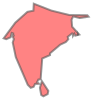

length in species dist polygon 88
length observationas >1900 88


10

processing species Axis_calamianensis
length data 11
length only including lon-lat 2 decimals 9
length unique lon-lat 3


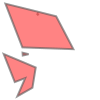

length in species dist polygon 2
length observationas >1900 2
processing species Axis_porcinus
length data 374
length only including lon-lat 2 decimals 364
length unique lon-lat 157


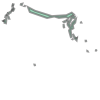

length in species dist polygon 12
length observationas >1900 12


14

processing species Babyrousa_celebensis
length data 11
length only including lon-lat 2 decimals 11
length unique lon-lat 3


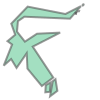

length in species dist polygon 2
length observationas >1900 2
processing species Bison_antiquus
length data 90
length only including lon-lat 2 decimals 87
length unique lon-lat 32


length in species dist polygon 0
length observationas >1900 0
processing species Bison_bison
length data 1274
length only including lon-lat 2 decimals 1241
length unique lon-lat 1121


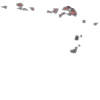

length in species dist polygon 431
length observationas >1900 431


12

processing species Bison_bonasus
length data 801
length only including lon-lat 2 decimals 800
length unique lon-lat 55


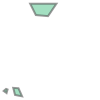

length in species dist polygon 30
length observationas >1900 29


14

processing species Blastocerus_dichotomus
length data 347
length only including lon-lat 2 decimals 345
length unique lon-lat 166


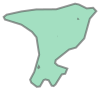

length in species dist polygon 166
length observationas >1900 166


23

processing species Blastomeryx_floridanus
length data 553
length only including lon-lat 2 decimals 553
length unique lon-lat 1


length in species dist polygon 0
length observationas >1900 0
processing species Bos_frontalis
length data 64
length only including lon-lat 2 decimals 64
length unique lon-lat 57


length in species dist polygon 0
length observationas >1900 0
processing species Bos_grunniens
length data 26
length only including lon-lat 2 decimals 23
length unique lon-lat 19


length in species dist polygon 0
length observationas >1900 0
processing species Bos_javanicus
length data 549
length only including lon-lat 2 decimals 548
length unique lon-lat 130


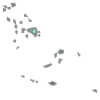

length in species dist polygon 87
length observationas >1900 87


14

processing species Bos_latifrons
length data 189
length only including lon-lat 2 decimals 186
length unique lon-lat 20


length in species dist polygon 0
length observationas >1900 0
processing species Bos_taurus
length data 10120
2067 0.00 00
length only including lon-lat 2 decimals 10072
length unique lon-lat 5723


length in species dist polygon 0
length observationas >1900 0
processing species Boselaphus_tragocamelus
length data 135
length only including lon-lat 2 decimals 133
length unique lon-lat 99


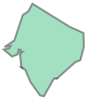

length in species dist polygon 54
length observationas >1900 54


24

processing species Bubalus_bubalis
length data 1786
length only including lon-lat 2 decimals 1765
length unique lon-lat 875


length in species dist polygon 0
length observationas >1900 0
processing species Budorcas_taxicolor
length data 20
length only including lon-lat 2 decimals 19
length unique lon-lat 13


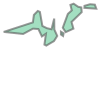

length in species dist polygon 8
length observationas >1900 8
processing species Calippus_maccartyi
length data 13
length only including lon-lat 2 decimals 10
length unique lon-lat 1


length in species dist polygon 0
length observationas >1900 0
processing species Calippus_martini
length data 11
length only including lon-lat 2 decimals 7
length unique lon-lat 5


length in species dist polygon 0
length observationas >1900 0
processing species Camelops_minidokae
length data 44
length only including lon-lat 2 decimals 44
length unique lon-lat 3


length in species dist polygon 0
length observationas >1900 0
processing species Camelus_dromedarius
length data 3801
length only including lon-lat 2 decimals 3728
length unique lon-lat 2944


length in species dist polygon 0
length observationas >1900 0
processing species Capra_hircus
length data 15464
length only including lon-lat 2 decimals 15275
length unique lon-lat 9768


length in species dist polygon 0
length observationas >1900 0
processing species Capra_ibex
length data 55646
length only including lon-lat 2 decimals 55467
length unique lon-lat 1643


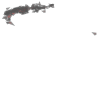

length in species dist polygon 91
length observationas >1900 91


11

processing species Capra_nubiana
length data 302
length only including lon-lat 2 decimals 285
length unique lon-lat 55


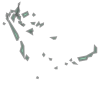

length in species dist polygon 31
length observationas >1900 31


14

processing species Capra_pyrenaica
length data 3734
length only including lon-lat 2 decimals 3328
length unique lon-lat 1305


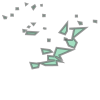

length in species dist polygon 704
length observationas >1900 704


16

processing species Capra_sibirica
length data 23
length only including lon-lat 2 decimals 19
length unique lon-lat 17


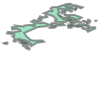

length in species dist polygon 12
length observationas >1900 12


15

processing species Capra_walie
length data 19
length only including lon-lat 2 decimals 19
length unique lon-lat 6


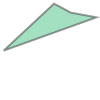

length in species dist polygon 3
length observationas >1900 3
processing species Capreolus_capreolus
length data 262504
length only including lon-lat 2 decimals 261222
length unique lon-lat 71597


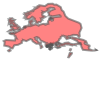

length in species dist polygon 58335
length observationas >1900 58329


20

processing species Capreolus_pygargus
length data 21
length only including lon-lat 2 decimals 21
length unique lon-lat 21


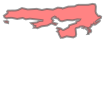

length in species dist polygon 20
length observationas >1900 20


19

processing species Capricornis_crispus
length data 446
length only including lon-lat 2 decimals 340
length unique lon-lat 61


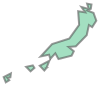

length in species dist polygon 47
length observationas >1900 47


20

processing species Capricornis_sumatraensis
length data 13
length only including lon-lat 2 decimals 9
length unique lon-lat 6


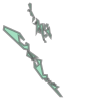

length in species dist polygon 0
length observationas >1900 0
processing species Capricornis_swinhoei
length data 30
length only including lon-lat 2 decimals 30
length unique lon-lat 30


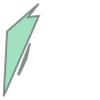

length in species dist polygon 21
length observationas >1900 21


21

processing species Capromeryx_arizonensis
length data 163
length only including lon-lat 2 decimals 105
length unique lon-lat 7


length in species dist polygon 0
length observationas >1900 0
processing species Cardiolophus_radinskyi
length data 26
length only including lon-lat 2 decimals 26
length unique lon-lat 8


length in species dist polygon 0
length observationas >1900 0
processing species Catagonus_wagneri
length data 28
length only including lon-lat 2 decimals 21
length unique lon-lat 12


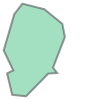

length in species dist polygon 11
length observationas >1900 11


18

processing species Cephalophus_dorsalis
length data 306
length only including lon-lat 2 decimals 291
length unique lon-lat 265


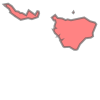

length in species dist polygon 264
length observationas >1900 264


21

processing species Cephalophus_jentinki
length data 110
length only including lon-lat 2 decimals 110
length unique lon-lat 102


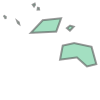

length in species dist polygon 36
length observationas >1900 36


21

processing species Cephalophus_natalensis
length data 105
length only including lon-lat 2 decimals 105
length unique lon-lat 101


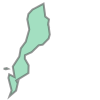

length in species dist polygon 47
length observationas >1900 47


23

processing species Cephalophus_niger
length data 70
length only including lon-lat 2 decimals 67
length unique lon-lat 45


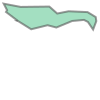

length in species dist polygon 39
length observationas >1900 38


18

processing species Cephalophus_nigrifrons
length data 36
length only including lon-lat 2 decimals 30
length unique lon-lat 27


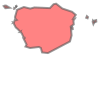

length in species dist polygon 19
length observationas >1900 19


23

processing species Cephalophus_rufilatus
length data 211
length only including lon-lat 2 decimals 208
length unique lon-lat 174


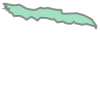

length in species dist polygon 170
length observationas >1900 170


22

processing species Cephalophus_silvicultor
length data 60
length only including lon-lat 2 decimals 49
length unique lon-lat 36


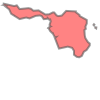

length in species dist polygon 29
length observationas >1900 29


24

processing species Cephalophus_zebra
length data 165
length only including lon-lat 2 decimals 165
length unique lon-lat 152


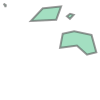

length in species dist polygon 46
length observationas >1900 46


18

processing species Ceratotherium_cottoni
length data 64
length only including lon-lat 2 decimals 63
length unique lon-lat 2


length in species dist polygon 0
length observationas >1900 0
processing species Ceratotherium_simum
length data 457
length only including lon-lat 2 decimals 457
length unique lon-lat 430


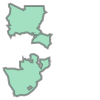

length in species dist polygon 423
length observationas >1900 423


20

processing species Cervus_elaphus
length data 58463
length only including lon-lat 2 decimals 57869
length unique lon-lat 22035


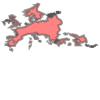

length in species dist polygon 16215
length observationas >1900 16203


15

processing species Cervus_nippon
length data 3961
length only including lon-lat 2 decimals 3596
length unique lon-lat 1538


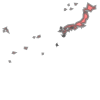

length in species dist polygon 95
length observationas >1900 95


14

processing species Connochaetes_gnou
length data 97
length only including lon-lat 2 decimals 97
length unique lon-lat 78


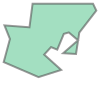

length in species dist polygon 40
length observationas >1900 40


18

processing species Connochaetes_taurinus
length data 852
length only including lon-lat 2 decimals 836
length unique lon-lat 630


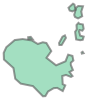

length in species dist polygon 503
length observationas >1900 503


22

processing species Cormohipparion_emsliei
length data 58
length only including lon-lat 2 decimals 51
length unique lon-lat 16


length in species dist polygon 0
length observationas >1900 0
processing species Dama_dama
length data 29324
length only including lon-lat 2 decimals 29047
length unique lon-lat 9419


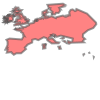

length in species dist polygon 7335
length observationas >1900 7326


10

processing species Damaliscus_korrigum
length data 36
length only including lon-lat 2 decimals 36
length unique lon-lat 29


length in species dist polygon 0
length observationas >1900 0
processing species Damaliscus_lunatus
length data 1113
length only including lon-lat 2 decimals 1106
length unique lon-lat 226


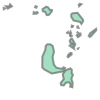

length in species dist polygon 175
length observationas >1900 175


19

processing species Damaliscus_pygargus
length data 228
length only including lon-lat 2 decimals 226
length unique lon-lat 193


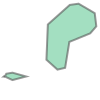

length in species dist polygon 99
length observationas >1900 99


20

processing species Desmathyus_brachydontus
length data 52
length only including lon-lat 2 decimals 51
length unique lon-lat 5


length in species dist polygon 0
length observationas >1900 0
processing species Diacodexis_ilicis
length data 205
length only including lon-lat 2 decimals 204
length unique lon-lat 41


length in species dist polygon 0
length observationas >1900 0
processing species Diceratherium_barbouri
length data 27
length only including lon-lat 2 decimals 27
length unique lon-lat 2


length in species dist polygon 0
length observationas >1900 0
processing species Diceros_bicornis
length data 414
length only including lon-lat 2 decimals 344
length unique lon-lat 187


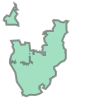

length in species dist polygon 180
length observationas >1900 180


17

processing species Dicotyles_fossilis
length data 155
length only including lon-lat 2 decimals 149
length unique lon-lat 10


length in species dist polygon 0
length observationas >1900 0
processing species Dromomeryx_texanus
length data 146
length only including lon-lat 2 decimals 146
length unique lon-lat 2


length in species dist polygon 0
length observationas >1900 0
processing species Elaphodus_cephalophus
length data 14
length only including lon-lat 2 decimals 11
length unique lon-lat 6


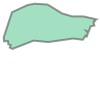

length in species dist polygon 5
length observationas >1900 5
processing species Elaphurus_davidianus
length data 26
length only including lon-lat 2 decimals 26
length unique lon-lat 1


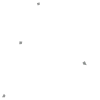

length in species dist polygon 0
length observationas >1900 0
processing species Eocoileus_gentryorum
length data 74
length only including lon-lat 2 decimals 71
length unique lon-lat 12


length in species dist polygon 0
length observationas >1900 0
processing species Equus_asinus
length data 1314
length only including lon-lat 2 decimals 1310
length unique lon-lat 961


length in species dist polygon 0
length observationas >1900 0
processing species Equus_caballus
length data 5092
length only including lon-lat 2 decimals 5046
length unique lon-lat 3130


length in species dist polygon 0
length observationas >1900 0
processing species Equus_conversidens
length data 372
length only including lon-lat 2 decimals 352
length unique lon-lat 24


length in species dist polygon 0
length observationas >1900 0
processing species Equus_ferus
length data 301
length only including lon-lat 2 decimals 240
length unique lon-lat 57


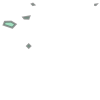

length in species dist polygon 0
length observationas >1900 0
processing species Equus_giganteus
length data 30
length only including lon-lat 2 decimals 30
length unique lon-lat 3


length in species dist polygon 0
length observationas >1900 0
processing species Equus_grevyi
length data 349
length only including lon-lat 2 decimals 344
length unique lon-lat 331


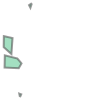

length in species dist polygon 272
length observationas >1900 272


13

processing species Equus_hartmannae
length data 73
length only including lon-lat 2 decimals 73
length unique lon-lat 71


length in species dist polygon 0
length observationas >1900 0
processing species Equus_hemionus
length data 367
length only including lon-lat 2 decimals 356
length unique lon-lat 120


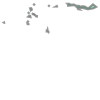

length in species dist polygon 57
length observationas >1900 57


15

processing species Equus_insulatus
length data 290
length only including lon-lat 2 decimals 253
length unique lon-lat 6


length in species dist polygon 0
length observationas >1900 0
processing species Equus_kiang
length data 11
length only including lon-lat 2 decimals 11
length unique lon-lat 11


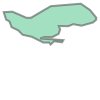

length in species dist polygon 10
length observationas >1900 10


12

processing species Equus_mexicanus
length data 30
length only including lon-lat 2 decimals 30
length unique lon-lat 1


length in species dist polygon 0
length observationas >1900 0
processing species Equus_niobrarensis
length data 37
length only including lon-lat 2 decimals 35
length unique lon-lat 5


length in species dist polygon 0
length observationas >1900 0
processing species Equus_przewalskii
length data 47
length only including lon-lat 2 decimals 47
length unique lon-lat 33


length in species dist polygon 0
length observationas >1900 0
processing species Equus_quagga
length data 1888
length only including lon-lat 2 decimals 1869
length unique lon-lat 1580


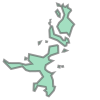

length in species dist polygon 1406
length observationas >1900 1406


13

processing species Equus_scotti
length data 152
length only including lon-lat 2 decimals 141
length unique lon-lat 11


length in species dist polygon 0
length observationas >1900 0
processing species Equus_zebra
length data 100
length only including lon-lat 2 decimals 100
length unique lon-lat 94


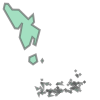

length in species dist polygon 44
length observationas >1900 44


12

processing species Eudorcas_rufifrons
length data 34
length only including lon-lat 2 decimals 34
length unique lon-lat 28


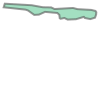

length in species dist polygon 17
length observationas >1900 17


19

processing species Eudorcas_thomsonii
length data 298
length only including lon-lat 2 decimals 292
length unique lon-lat 211


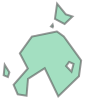

length in species dist polygon 185
length observationas >1900 185


19

processing species Floridaceras_whitei
length data 90
length only including lon-lat 2 decimals 90
length unique lon-lat 3


length in species dist polygon 0
length observationas >1900 0
processing species Floridachoerus_olseni
length data 41
length only including lon-lat 2 decimals 41
length unique lon-lat 1


length in species dist polygon 0
length observationas >1900 0
processing species Floridameryx_floridanus
length data 23
length only including lon-lat 2 decimals 2
length unique lon-lat 2


length in species dist polygon 0
length observationas >1900 0
processing species Floridatragulus_dolichanthereus
length data 17
length only including lon-lat 2 decimals 17
length unique lon-lat 1


length in species dist polygon 0
length observationas >1900 0
processing species Gazella_bennettii
length data 47
length only including lon-lat 2 decimals 47
length unique lon-lat 38


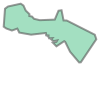

length in species dist polygon 23
length observationas >1900 23


18

processing species Gazella_cuvieri
length data 303
length only including lon-lat 2 decimals 303
length unique lon-lat 3


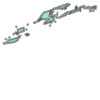

length in species dist polygon 2
length observationas >1900 2
processing species Gazella_dorcas
length data 3628
length only including lon-lat 2 decimals 3441
length unique lon-lat 1277


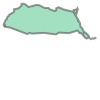

length in species dist polygon 689
length observationas >1900 689


15

processing species Gazella_gazella
length data 16784
length only including lon-lat 2 decimals 15725
length unique lon-lat 4825


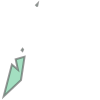

length in species dist polygon 3496
length observationas >1900 3496


16

processing species Gazella_leptoceros
length data 18
length only including lon-lat 2 decimals 15
length unique lon-lat 9


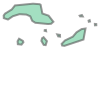

length in species dist polygon 0
length observationas >1900 0
processing species Gazella_subgutturosa
length data 56
length only including lon-lat 2 decimals 52
length unique lon-lat 27


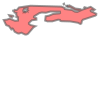

length in species dist polygon 17
length observationas >1900 17


21

processing species Giraffa_camelopardalis
length data 878
length only including lon-lat 2 decimals 876
length unique lon-lat 759


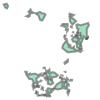

length in species dist polygon 440
length observationas >1900 440


23

processing species Giraffa_giraffa
length data 664
length only including lon-lat 2 decimals 664
length unique lon-lat 634


length in species dist polygon 0
length observationas >1900 0
processing species Giraffa_reticulata
length data 81
length only including lon-lat 2 decimals 81
length unique lon-lat 73


length in species dist polygon 0
length observationas >1900 0
processing species Giraffa_tippelskirchi
length data 361
length only including lon-lat 2 decimals 361
length unique lon-lat 275


length in species dist polygon 0
length observationas >1900 0
processing species Hemiauchenia_gracilis
length data 25
length only including lon-lat 2 decimals 20
length unique lon-lat 4


length in species dist polygon 0
length observationas >1900 0
processing species Hemiauchenia_macrocephala
length data 195
length only including lon-lat 2 decimals 170
length unique lon-lat 22


length in species dist polygon 0
length observationas >1900 0
processing species Hemitragus_jemlahicus
length data 40
length only including lon-lat 2 decimals 39
length unique lon-lat 16


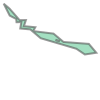

length in species dist polygon 7
length observationas >1900 7
processing species Hexameryx_simpsoni
length data 11
length only including lon-lat 2 decimals 10
length unique lon-lat 7


length in species dist polygon 0
length observationas >1900 0
processing species Hipparion_libycum
length data 30
length only including lon-lat 2 decimals 30
length unique lon-lat 1


length in species dist polygon 0
length observationas >1900 0
processing species Hipparion_plicatile
length data 33
length only including lon-lat 2 decimals 23
length unique lon-lat 10


length in species dist polygon 0
length observationas >1900 0
processing species Hipparion_trampasense
length data 11
length only including lon-lat 2 decimals 10
length unique lon-lat 5


length in species dist polygon 0
length observationas >1900 0
processing species Hippocamelus_antisensis
length data 14
length only including lon-lat 2 decimals 14
length unique lon-lat 11


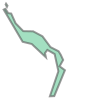

length in species dist polygon 5
length observationas >1900 5
processing species Hippocamelus_bisulcus
length data 21
length only including lon-lat 2 decimals 21
length unique lon-lat 16


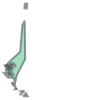

length in species dist polygon 7
length observationas >1900 7
processing species Hippopotamus_amphibius
length data 1222
length only including lon-lat 2 decimals 1207
length unique lon-lat 976


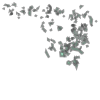

length in species dist polygon 530
length observationas >1900 530


23

processing species Hippotherium_ingenuum
length data 39
length only including lon-lat 2 decimals 27
length unique lon-lat 15


length in species dist polygon 0
length observationas >1900 0
processing species Hippotragus_equinus
length data 1731
length only including lon-lat 2 decimals 1724
length unique lon-lat 1586


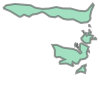

length in species dist polygon 1555
length observationas >1900 1555


20

processing species Hippotragus_niger
length data 144
length only including lon-lat 2 decimals 133
length unique lon-lat 118


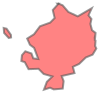

length in species dist polygon 74
length observationas >1900 74


18

processing species Hydropotes_inermis
length data 4071
length only including lon-lat 2 decimals 4070
length unique lon-lat 485


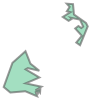

length in species dist polygon 39
length observationas >1900 39


19

processing species Hyemoschus_aquaticus
length data 46
length only including lon-lat 2 decimals 43
length unique lon-lat 36


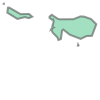

length in species dist polygon 34
length observationas >1900 34


21

processing species Hylochoerus_meinertzhageni
length data 98
length only including lon-lat 2 decimals 45
length unique lon-lat 42


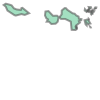

length in species dist polygon 38
length observationas >1900 38


27

processing species Hyracotherium_grangeri
length data 314
length only including lon-lat 2 decimals 309
length unique lon-lat 31


length in species dist polygon 0
length observationas >1900 0
processing species Hyracotherium_sandrae
length data 878
length only including lon-lat 2 decimals 877
length unique lon-lat 52


length in species dist polygon 0
length observationas >1900 0
processing species Kobus_ellipsiprymnus
length data 2017
length only including lon-lat 2 decimals 1997
length unique lon-lat 912


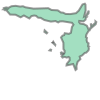

length in species dist polygon 846
length observationas >1900 846


21

processing species Kobus_kob
length data 3052
length only including lon-lat 2 decimals 3028
length unique lon-lat 2504


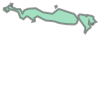

length in species dist polygon 2494
length observationas >1900 2494


10

processing species Kobus_leche
length data 93
length only including lon-lat 2 decimals 88
length unique lon-lat 62


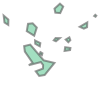

length in species dist polygon 46
length observationas >1900 46


12

processing species Kobus_megaceros
length data 63
length only including lon-lat 2 decimals 63
length unique lon-lat 62


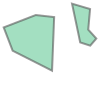

length in species dist polygon 60
length observationas >1900 60


16

processing species Kobus_vardonii
length data 103
length only including lon-lat 2 decimals 100
length unique lon-lat 75


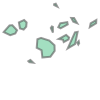

length in species dist polygon 52
length observationas >1900 52


15

processing species Kyptoceras_amatorum
length data 10
length only including lon-lat 2 decimals 9
length unique lon-lat 2


length in species dist polygon 0
length observationas >1900 0
processing species Lama_glama
length data 360
length only including lon-lat 2 decimals 353
length unique lon-lat 309


length in species dist polygon 0
length observationas >1900 0
processing species Leptauchenia_calcarata
length data 60
length only including lon-lat 2 decimals 16
length unique lon-lat 2


length in species dist polygon 0
length observationas >1900 0
processing species Leptauchenia_minima
length data 32
length only including lon-lat 2 decimals 14
length unique lon-lat 3


length in species dist polygon 0
length observationas >1900 0
processing species Leptomeryx_evansi
length data 204
length only including lon-lat 2 decimals 58
length unique lon-lat 5


length in species dist polygon 0
length observationas >1900 0
processing species Leptomeryx_speciosus
length data 40
length only including lon-lat 2 decimals 24
length unique lon-lat 2


length in species dist polygon 0
length observationas >1900 0
processing species Litocranius_walleri
length data 259
length only including lon-lat 2 decimals 251
length unique lon-lat 219


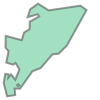

length in species dist polygon 195
length observationas >1900 190


20

processing species Machaeromeryx_gilchristensis
length data 296
length only including lon-lat 2 decimals 296
length unique lon-lat 1


length in species dist polygon 0
length observationas >1900 0
processing species Madoqua_guentheri
length data 52
length only including lon-lat 2 decimals 49
length unique lon-lat 43


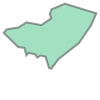

length in species dist polygon 35
length observationas >1900 35


18

processing species Madoqua_kirkii
length data 265
length only including lon-lat 2 decimals 252
length unique lon-lat 174


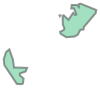

length in species dist polygon 165
length observationas >1900 165


15

processing species Madoqua_saltiana
length data 30
length only including lon-lat 2 decimals 21
length unique lon-lat 15


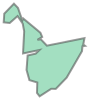

length in species dist polygon 8
length observationas >1900 3
processing species Mazama_americana
length data 2112
length only including lon-lat 2 decimals 2067
length unique lon-lat 994


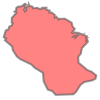

length in species dist polygon 822
length observationas >1900 822


17

processing species Mazama_gouazoubira
length data 720
length only including lon-lat 2 decimals 697
length unique lon-lat 293


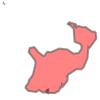

length in species dist polygon 114
length observationas >1900 113


19

processing species Mazama_nana
length data 161
length only including lon-lat 2 decimals 161
length unique lon-lat 77


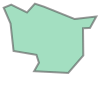

length in species dist polygon 77
length observationas >1900 77


12

processing species Mazama_pandora
length data 288
length only including lon-lat 2 decimals 287
length unique lon-lat 84


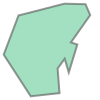

length in species dist polygon 80
length observationas >1900 80


15

processing species Mazama_rufina
length data 24
length only including lon-lat 2 decimals 22
length unique lon-lat 19


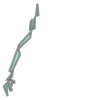

length in species dist polygon 5
length observationas >1900 5
processing species Mazama_temama
length data 215
length only including lon-lat 2 decimals 215
length unique lon-lat 117


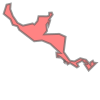

length in species dist polygon 99
length observationas >1900 99


14

processing species Mazama_zetta
length data 20
length only including lon-lat 2 decimals 20
length unique lon-lat 10


length in species dist polygon 0
length observationas >1900 0
processing species Merychippus_gunteri
length data 98
length only including lon-lat 2 decimals 2
length unique lon-lat 2


length in species dist polygon 0
length observationas >1900 0
processing species Merychippus_tertius
length data 14
length only including lon-lat 2 decimals 0
length unique lon-lat 0


length in species dist polygon 0
length observationas >1900 0
processing species Merycoidodon_culbertsonii
length data 21
length only including lon-lat 2 decimals 11
length unique lon-lat 5


length in species dist polygon 0
length observationas >1900 0
processing species Moschiola_meminna
length data 15
length only including lon-lat 2 decimals 13
length unique lon-lat 7


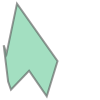

length in species dist polygon 4
length observationas >1900 4
processing species Muntiacus_atherodes
length data 11
length only including lon-lat 2 decimals 8
length unique lon-lat 4


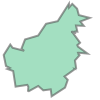

length in species dist polygon 3
length observationas >1900 3
processing species Muntiacus_muntjak
length data 88
length only including lon-lat 2 decimals 80
length unique lon-lat 54


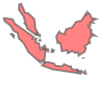

length in species dist polygon 4
length observationas >1900 4
processing species Muntiacus_reevesi
length data 12272
length only including lon-lat 2 decimals 12272
length unique lon-lat 3748


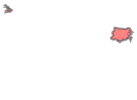

length in species dist polygon 3181
length observationas >1900 3180


18

processing species Nanger_dama
length data 393
length only including lon-lat 2 decimals 392
length unique lon-lat 4


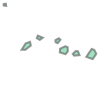

length in species dist polygon 0
length observationas >1900 0
processing species Nanger_granti
length data 946
length only including lon-lat 2 decimals 932
length unique lon-lat 834


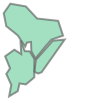

length in species dist polygon 814
length observationas >1900 814


14

processing species Nanger_soemmerringii
length data 42
length only including lon-lat 2 decimals 26
length unique lon-lat 18


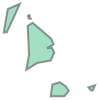

length in species dist polygon 14
length observationas >1900 14


21

processing species Nannippus_aztecus
length data 188
length only including lon-lat 2 decimals 166
length unique lon-lat 38


length in species dist polygon 0
length observationas >1900 0
processing species Neohipparion_eurystyle
length data 55
length only including lon-lat 2 decimals 49
length unique lon-lat 20


length in species dist polygon 0
length observationas >1900 0
processing species Neohipparion_floresi
length data 178
length only including lon-lat 2 decimals 178
length unique lon-lat 1


length in species dist polygon 0
length observationas >1900 0
processing species Neotragus_batesi
length data 44
length only including lon-lat 2 decimals 19
length unique lon-lat 15


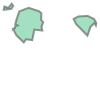

length in species dist polygon 11
length observationas >1900 11


17

processing species Neotragus_moschatus
length data 18
length only including lon-lat 2 decimals 13
length unique lon-lat 11


length in species dist polygon 0
length observationas >1900 0
processing species Neotragus_pygmaeus
length data 93
length only including lon-lat 2 decimals 87
length unique lon-lat 59


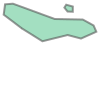

length in species dist polygon 59
length observationas >1900 59


19

processing species Nothokemas_floridanus
length data 72
length only including lon-lat 2 decimals 72
length unique lon-lat 2


length in species dist polygon 0
length observationas >1900 0
processing species Odocoileus_hemionus
length data 9748
length only including lon-lat 2 decimals 9693
length unique lon-lat 8362


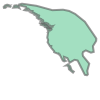

length in species dist polygon 7286
length observationas >1900 7270


20

processing species Odocoileus_virginianus
length data 22670
length only including lon-lat 2 decimals 22412
length unique lon-lat 16929


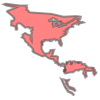

length in species dist polygon 14965
length observationas >1900 14922


23

processing species Oreamnos_americanus
length data 617
length only including lon-lat 2 decimals 615
length unique lon-lat 514


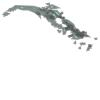

length in species dist polygon 189
length observationas >1900 187


20

processing species Oreodon_bullatus
length data 14
length only including lon-lat 2 decimals 5
length unique lon-lat 2


length in species dist polygon 0
length observationas >1900 0
processing species Oreotragus_oreotragus
length data 276
length only including lon-lat 2 decimals 266
length unique lon-lat 226


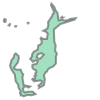

length in species dist polygon 218
length observationas >1900 218


22

processing species Oryx_beisa
length data 231
length only including lon-lat 2 decimals 226
length unique lon-lat 212


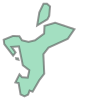

length in species dist polygon 147
length observationas >1900 147


11

processing species Oryx_dammah
length data 65
length only including lon-lat 2 decimals 65
length unique lon-lat 6


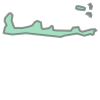

length in species dist polygon 1
length observationas >1900 1
processing species Oryx_gazella
length data 525
length only including lon-lat 2 decimals 487
length unique lon-lat 345


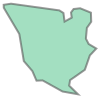

length in species dist polygon 282
length observationas >1900 282


13

processing species Oryx_leucoryx
length data 325
length only including lon-lat 2 decimals 324
length unique lon-lat 14


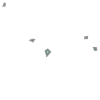

length in species dist polygon 0
length observationas >1900 0
processing species Ourebia_ourebi
length data 1685
length only including lon-lat 2 decimals 1648
length unique lon-lat 740


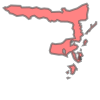

length in species dist polygon 730
length observationas >1900 730


15

processing species Ovibos_moschatus
length data 3210
length only including lon-lat 2 decimals 3183
length unique lon-lat 2071


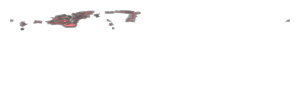

length in species dist polygon 98
length observationas >1900 98


17

processing species Ovis_ammon
length data 344
length only including lon-lat 2 decimals 312
length unique lon-lat 210


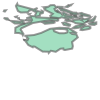

length in species dist polygon 6
length observationas >1900 6
processing species Ovis_aries
length data 5046
length only including lon-lat 2 decimals 4846
length unique lon-lat 1960


length in species dist polygon 0
length observationas >1900 0
processing species Ovis_canadensis
length data 2556
length only including lon-lat 2 decimals 2515
length unique lon-lat 2062


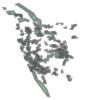

length in species dist polygon 656
length observationas >1900 654


16

processing species Ovis_dalli
length data 192
length only including lon-lat 2 decimals 186
length unique lon-lat 126


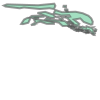

length in species dist polygon 77
length observationas >1900 76


11

processing species Ovis_gmelini
length data 459
length only including lon-lat 2 decimals 459
length unique lon-lat 256


length in species dist polygon 0
length observationas >1900 0
processing species Ovis_gmelinii
length data 2372
length only including lon-lat 2 decimals 2372
length unique lon-lat 183


length in species dist polygon 0
length observationas >1900 0
processing species Ovis_nivicola
length data 65
length only including lon-lat 2 decimals 2
length unique lon-lat 2


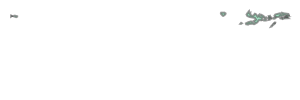

length in species dist polygon 0
length observationas >1900 0
processing species Ozotoceros_bezoarticus
length data 46
length only including lon-lat 2 decimals 46
length unique lon-lat 26


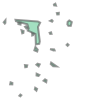

length in species dist polygon 5
length observationas >1900 5
processing species Pantolestes_metsiacus
length data 106
length only including lon-lat 2 decimals 106
length unique lon-lat 10


length in species dist polygon 0
length observationas >1900 0
processing species Parahippus_leonensis
length data 13994
length only including lon-lat 2 decimals 13994
length unique lon-lat 5


length in species dist polygon 0
length observationas >1900 0
processing species Paratoceras_coatesi
length data 57
length only including lon-lat 2 decimals 57
length unique lon-lat 5


length in species dist polygon 0
length observationas >1900 0
processing species Paratoceras_tedfordi
length data 18
length only including lon-lat 2 decimals 18
length unique lon-lat 1


length in species dist polygon 0
length observationas >1900 0
processing species Pecari_tajacu
length data 4069
length only including lon-lat 2 decimals 3974
length unique lon-lat 1910


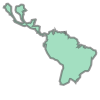

length in species dist polygon 1729
length observationas >1900 1715


14

processing species Pediomeryx_hamiltoni
length data 14
length only including lon-lat 2 decimals 1
length unique lon-lat 1


length in species dist polygon 0
length observationas >1900 0
processing species Pelea_capreolus
length data 55
length only including lon-lat 2 decimals 55
length unique lon-lat 55


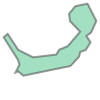

length in species dist polygon 43
length observationas >1900 43


16

processing species Phacochoerus_aethiopicus
length data 160
length only including lon-lat 2 decimals 144
length unique lon-lat 92


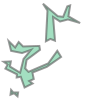

length in species dist polygon 11
length observationas >1900 10


25

processing species Phacochoerus_africanus
length data 3214
length only including lon-lat 2 decimals 3191
length unique lon-lat 2023


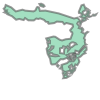

length in species dist polygon 1960
length observationas >1900 1960


23

processing species Philantomba_maxwellii
length data 302
length only including lon-lat 2 decimals 296
length unique lon-lat 264


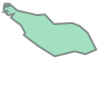

length in species dist polygon 259
length observationas >1900 259


22

processing species Philantomba_monticola
length data 265
length only including lon-lat 2 decimals 228
length unique lon-lat 133


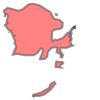

length in species dist polygon 105
length observationas >1900 105


22

processing species Platygonus_bicalcaratus
length data 19
length only including lon-lat 2 decimals 19
length unique lon-lat 1


length in species dist polygon 0
length observationas >1900 0
processing species Platygonus_compressus
length data 10
length only including lon-lat 2 decimals 10
length unique lon-lat 6


length in species dist polygon 0
length observationas >1900 0
processing species Platygonus_vetus
length data 673
length only including lon-lat 2 decimals 673
length unique lon-lat 1


length in species dist polygon 0
length observationas >1900 0
processing species Pliauchenia_vera
length data 126
length only including lon-lat 2 decimals 125
length unique lon-lat 12


length in species dist polygon 0
length observationas >1900 0
processing species Pliohippus_hondurensis
length data 95
length only including lon-lat 2 decimals 10
length unique lon-lat 7


length in species dist polygon 0
length observationas >1900 0
processing species Pliohippus_mexicanus
length data 15
length only including lon-lat 2 decimals 14
length unique lon-lat 10


length in species dist polygon 0
length observationas >1900 0
processing species Potamochoerus_larvatus
length data 79
length only including lon-lat 2 decimals 68
length unique lon-lat 58


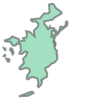

length in species dist polygon 43
length observationas >1900 43


23

processing species Potamochoerus_porcus
length data 255
length only including lon-lat 2 decimals 250
length unique lon-lat 182


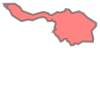

length in species dist polygon 112
length observationas >1900 112


21

processing species Procamelus_edensis
length data 48
length only including lon-lat 2 decimals 45
length unique lon-lat 9


length in species dist polygon 0
length observationas >1900 0
processing species Procapra_picticaudata
length data 14
length only including lon-lat 2 decimals 13
length unique lon-lat 13


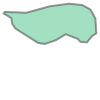

length in species dist polygon 11
length observationas >1900 11


22

processing species Pseudhipparion_simpsoni
length data 33
length only including lon-lat 2 decimals 27
length unique lon-lat 6


length in species dist polygon 0
length observationas >1900 0
processing species Pseudhipparion_skinneri
length data 27
length only including lon-lat 2 decimals 27
length unique lon-lat 11


length in species dist polygon 0
length observationas >1900 0
processing species Pseudois_nayaur
length data 26
length only including lon-lat 2 decimals 26
length unique lon-lat 22


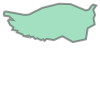

length in species dist polygon 19
length observationas >1900 19


16

processing species Pseudoprotoceras_longinaris
length data 11
length only including lon-lat 2 decimals 8
length unique lon-lat 1


length in species dist polygon 0
length observationas >1900 0
processing species Pudu_mephistophiles
length data 27
length only including lon-lat 2 decimals 10
length unique lon-lat 7


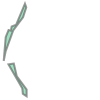

length in species dist polygon 6
length observationas >1900 6
processing species Pudu_puda
length data 159
length only including lon-lat 2 decimals 153
length unique lon-lat 103


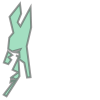

length in species dist polygon 97
length observationas >1900 97


10

processing species Rangifer_tarandus
length data 6167
length only including lon-lat 2 decimals 5712
length unique lon-lat 4291


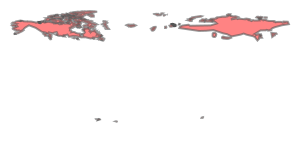

length in species dist polygon 2928
length observationas >1900 2927


18

processing species Raphicerus_campestris
length data 390
length only including lon-lat 2 decimals 372
length unique lon-lat 318


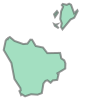

length in species dist polygon 313
length observationas >1900 313


22

processing species Raphicerus_melanotis
length data 33
length only including lon-lat 2 decimals 33
length unique lon-lat 32


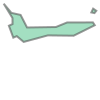

length in species dist polygon 25
length observationas >1900 25


21

processing species Raphicerus_sharpei
length data 54
length only including lon-lat 2 decimals 52
length unique lon-lat 43


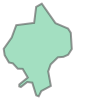

length in species dist polygon 42
length observationas >1900 42


19

processing species Redunca_arundinum
length data 103
length only including lon-lat 2 decimals 96
length unique lon-lat 85


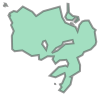

length in species dist polygon 69
length observationas >1900 69


18

processing species Redunca_fulvorufula
length data 64
length only including lon-lat 2 decimals 59
length unique lon-lat 39


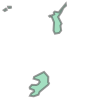

length in species dist polygon 33
length observationas >1900 33


20

processing species Redunca_redunca
length data 666
length only including lon-lat 2 decimals 660
length unique lon-lat 597


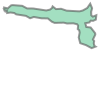

length in species dist polygon 590
length observationas >1900 590


16

processing species Rhinoceros_proterus
length data 230
length only including lon-lat 2 decimals 230
length unique lon-lat 3


length in species dist polygon 0
length observationas >1900 0
processing species Rhinoceros_unicornis
length data 53
length only including lon-lat 2 decimals 51
length unique lon-lat 31


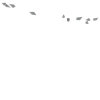

length in species dist polygon 10
length observationas >1900 10


21

processing species Rucervus_duvaucelii
length data 24
length only including lon-lat 2 decimals 20
length unique lon-lat 11


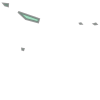

length in species dist polygon 1
length observationas >1900 1
processing species Rupicapra_pyrenaica
length data 12404
length only including lon-lat 2 decimals 12340
length unique lon-lat 1230


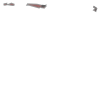

length in species dist polygon 659
length observationas >1900 659


20

processing species Rupicapra_rupicapra
length data 37626
length only including lon-lat 2 decimals 37618
length unique lon-lat 1333


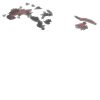

length in species dist polygon 693
length observationas >1900 693


20

processing species Rusa_marianna
length data 46
length only including lon-lat 2 decimals 33
length unique lon-lat 10


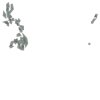

length in species dist polygon 6
length observationas >1900 6
processing species Rusa_timorensis
length data 1141
length only including lon-lat 2 decimals 1140
length unique lon-lat 635


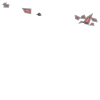

length in species dist polygon 1
length observationas >1900 1
processing species Rusa_unicolor
length data 1283
length only including lon-lat 2 decimals 1264
length unique lon-lat 836


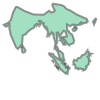

length in species dist polygon 124
length observationas >1900 124


14

processing species Subantilocapra_garciae
length data 10
length only including lon-lat 2 decimals 10
length unique lon-lat 5


length in species dist polygon 0
length observationas >1900 0
processing species Sus_barbatus
length data 208
length only including lon-lat 2 decimals 165
length unique lon-lat 54


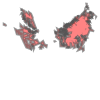

length in species dist polygon 17
length observationas >1900 17


13

processing species Sus_cebifrons
length data 26
length only including lon-lat 2 decimals 23
length unique lon-lat 14


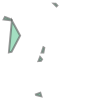

length in species dist polygon 0
length observationas >1900 0
processing species Sus_celebensis
length data 19
length only including lon-lat 2 decimals 19
length unique lon-lat 3


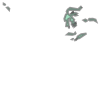

length in species dist polygon 1
length observationas >1900 1
processing species Sus_philippensis
length data 43
length only including lon-lat 2 decimals 39
length unique lon-lat 18


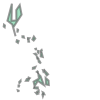

length in species dist polygon 2
length observationas >1900 2
processing species Sus_scrofa
length data 85419
length only including lon-lat 2 decimals 82424
length unique lon-lat 22987


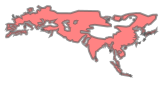

length in species dist polygon 14398
length observationas >1900 14393


11

processing species Sylvicapra_grimmia
length data 2319
length only including lon-lat 2 decimals 2288
length unique lon-lat 1260


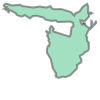

length in species dist polygon 1239
length observationas >1900 1239


19

processing species Syncerus_caffer
length data 2978
length only including lon-lat 2 decimals 2945
length unique lon-lat 1762


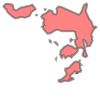

length in species dist polygon 1714
length observationas >1900 1714


16

processing species Tanupolama_mirifica
length data 162
length only including lon-lat 2 decimals 140
length unique lon-lat 40


length in species dist polygon 0
length observationas >1900 0
processing species Tapiravus_polkensis
length data 11
length only including lon-lat 2 decimals 11
length unique lon-lat 7


length in species dist polygon 0
length observationas >1900 0
processing species Tapirella_bairdii
length data 283
length only including lon-lat 2 decimals 264
length unique lon-lat 233


length in species dist polygon 0
length observationas >1900 0
processing species Tapirus_haysii
length data 10
length only including lon-lat 2 decimals 5
length unique lon-lat 5


length in species dist polygon 0
length observationas >1900 0
processing species Tapirus_lundeliusi
length data 166
length only including lon-lat 2 decimals 166
length unique lon-lat 4


length in species dist polygon 0
length observationas >1900 0
processing species Tapirus_pinchaque
length data 16
length only including lon-lat 2 decimals 16
length unique lon-lat 13


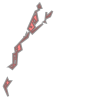

length in species dist polygon 7
length observationas >1900 7
processing species Tapirus_terrestris
length data 3511
length only including lon-lat 2 decimals 3492
length unique lon-lat 1638


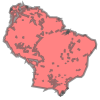

length in species dist polygon 1615
length observationas >1900 1615


19

processing species Tapirus_veroensis
length data 291
length only including lon-lat 2 decimals 252
length unique lon-lat 45


length in species dist polygon 0
length observationas >1900 0
processing species Taurotragus_oryx
length data 986
length only including lon-lat 2 decimals 979
length unique lon-lat 102


length in species dist polygon 0
length observationas >1900 0
processing species Tayassu_pecari
length data 1095
length only including lon-lat 2 decimals 1046
length unique lon-lat 415


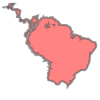

length in species dist polygon 318
length observationas >1900 317


15

processing species Teleoceras_hicksi
length data 205
length only including lon-lat 2 decimals 199
length unique lon-lat 10


length in species dist polygon 0
length observationas >1900 0
processing species Tragelaphus_angasii
length data 295
length only including lon-lat 2 decimals 294
length unique lon-lat 246


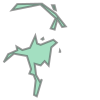

length in species dist polygon 167
length observationas >1900 167


20

processing species Tragelaphus_buxtoni
length data 38
length only including lon-lat 2 decimals 36
length unique lon-lat 23


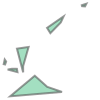

length in species dist polygon 13
length observationas >1900 13


20

processing species Tragelaphus_eurycerus
length data 72
length only including lon-lat 2 decimals 71
length unique lon-lat 66


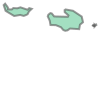

length in species dist polygon 30
length observationas >1900 30


22

processing species Tragelaphus_imberbis
length data 113
length only including lon-lat 2 decimals 99
length unique lon-lat 76


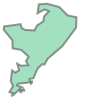

length in species dist polygon 66
length observationas >1900 65


21

processing species Tragelaphus_oryx
length data 383
length only including lon-lat 2 decimals 382
length unique lon-lat 365


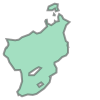

length in species dist polygon 344
length observationas >1900 344


17

processing species Tragelaphus_scriptus
length data 2524
length only including lon-lat 2 decimals 2490
length unique lon-lat 1376


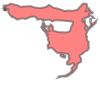

length in species dist polygon 1336
length observationas >1900 1336


21

processing species Tragelaphus_spekii
length data 93
length only including lon-lat 2 decimals 81
length unique lon-lat 70


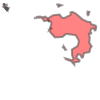

length in species dist polygon 30
length observationas >1900 30


19

processing species Tragelaphus_strepsiceros
length data 865
length only including lon-lat 2 decimals 837
length unique lon-lat 653


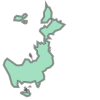

length in species dist polygon 565
length observationas >1900 565


25

processing species Tragulus_javanicus
length data 65
length only including lon-lat 2 decimals 63
length unique lon-lat 23


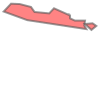

length in species dist polygon 2
length observationas >1900 2
processing species Tragulus_kanchil
length data 28
length only including lon-lat 2 decimals 26
length unique lon-lat 14


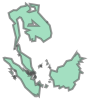

length in species dist polygon 14
length observationas >1900 14


17

processing species Tragulus_napu
length data 23
length only including lon-lat 2 decimals 20
length unique lon-lat 14


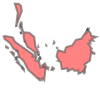

length in species dist polygon 10
length observationas >1900 10


14

processing species Tragulus_nigricans
length data 14
length only including lon-lat 2 decimals 9
length unique lon-lat 3


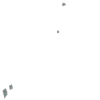

length in species dist polygon 2
length observationas >1900 1
processing species Vicugna_pacos
length data 39
length only including lon-lat 2 decimals 39
length unique lon-lat 32


length in species dist polygon 0
length observationas >1900 0
processing species Vicugna_vicugna
length data 70
length only including lon-lat 2 decimals 69
length unique lon-lat 63


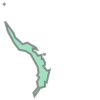

length in species dist polygon 61
length observationas >1900 61


16

In [13]:
#create txt file with name of species included after filtering
taxa_list=open(file_dir+'/data/SQL_filtered_gbif/taxa_list.txt',"w")

for spec in species:
    data=df2.loc[df2['species'] == spec]
    
    if len(data.index)>= 10:
        spec = spec.replace(" ","_")
        print("processing species %s"%spec)
        #check capriolus data as example
        data=pd.read_csv(file_dir+'/data/SQL_raw_gbif/%s_raw_data.csv'%spec)
        print("length data", len(data.index))

        #check number of decimals longitude and latitude
        str_lat=(pd.Series.tolist(data["decimal_latitude"].astype(str)))
        str_lon=(pd.Series.tolist(data["decimal_longitude"].astype(str)))
        dec_lat=[]
        dec_lon=[]

        for i in range(len(str_lat)):
       # print("row %s"%i)
            if "e" in str_lat[i]:
                str_lat[i]="0.00"
                decla = str_lat[i].split(".")[1]
                print(i, str_lat[i],decla)
                dec_lat.append(int(len(decla)))
            else:
                decla = str_lat[i].split(".")[1]
                #print(str_lat[i],decla)
                dec_lat.append(int(len(decla)))
        for i in range(len(str_lon)):
            declo=str_lon[i].split(".")[1]
            dec_lon.append(int(len(declo)))
        #x.split(".")[1] for x in str_lat]


        #dec_lon=[x.split(".")[1] for x in str_lon]
        #dec_lat=[int(len(x)) for x in dec_lat]
        #dec_lon=[int(len(x)) for x in dec_lon]
        data["dec_lat"]=dec_lat
        data["dec_lon"]=dec_lon

        #filter only include those with min. 2 points
        data=data[data["dec_lat"] >= 2]
        data=data[data["dec_lon"] >= 2]
        print("length only including lon-lat 2 decimals",len(data.index))

        ##turn lat/lon into  set of points
        #data['decimal_latitude']=data['decimal_latitude'].round(2)
        #data['decimal_longitude']=data['decimal_longitude'].round(2)
        data['coordinates'] = list(zip(data["decimal_longitude"], data["decimal_latitude"]))
        data['lonlat'] = list(zip(data["decimal_longitude"], data["decimal_latitude"]))
        data['coordinates'] = data["coordinates"].apply(Point)

        #only keep records with unique lon-lat 
        data = data.drop_duplicates('lonlat')
        print("length unique lon-lat",len(data.index))


        ###########################################
        ###########################################
        ##Access the relevant shapefiles for the species
        speci=spec.replace("_"," ")
        dist_shp_spec = dist_shp[dist_shp["binomial"]== "%s"%speci]
        poly_spec = dist_shp_spec[["geometry"]]
        ##merge the polygons
        iucn_poly_spec= poly_spec.unary_union
        Q3 = iucn_poly_spec.simplify(0.3)
        Q3

        if Q3.is_valid== False:
            Q3 = Q3.buffer(0)

        condition_list=[]

        for point in data["coordinates"]:
            output= point.within(Q3)
            condition_list.append(output)

        #keep records that are in species range
        data["in_dist_polygon"]=condition_list
        data2=data[data.in_dist_polygon == True]
        print("length in species dist polygon",len(data2.index))

        ########################################################
        #########################################################set date column to datetime format and extract year
        data2['event_date'] = pd.to_datetime(data2['event_date'])
        data2['year'] = data2['event_date'].dt.year
        data2['month']= data2['event_date'].dt.month

        #set date column to datetime format and extract year
        data2['event_date'] = pd.to_datetime(data2['event_date'])
        data2['year'] = data2['event_date'].dt.year
        data2['month']= data2['event_date'].dt.month

        #only include observations >1900
        data3=data2[data2.year >= 1900]
        print("length observationas >1900", len(data3.index))
        #save to csv
        if len(data3.index)>=10:
            data3.to_csv(file_dir+'/data/SQL_filtered_gbif/%s_filtered_data.csv'%spec)
            taxa_list.write(spec+"\n")
            
#close text file
taxa_list.close()